# Final Project Report
## Noam Siegel
### Physiological Signal Processing, Ben Gurion University
 #### 367-2-6351



In [85]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from msc.config import get_config
from msc.dataset import RawDataset, PSPDataset
from msc.dataset.dataset import get_datasets_df
from scripts.psp.analysis.imshow_dataset import plot_feature_window
from scripts.psp.analysis.data_visualizations import plot_pca_projection
from scripts.psp.build_dataset import build_dataset
from scripts.psp.training import classifier_comparison

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load configurations

In [2]:
config = get_config()
config

{'PATH': {'LOCAL': {'RAW_DATASET': 'C:\\raw_data\\epilepsiae',
   'RESULTS': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results',
   'PSP_DATASET': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results\\epilepsiae'},
  'BGUCLUSTER': {'RAW_DATASET': '/cs_storage/noamsi/raw_data/epilepsiae/',
   'RESULTS': '/cs_storage/noamsi/results/',
   'PSP_DATASET': '/cs_storage/noamsi/results/epilepsiae/'},
  'MIRIAM': {'RAW_DATASET': '\\\\132.72.65.115\\epilepsy_data\\Epilepsiea\\raw_data'}},
 'TASK': {'PICKS': 'one_channel',
  'RESAMPLE': '256',
  'PREICTAL_MIN_DIFF_HOURS': '1',
  'INTERICTAL_MIN_DIFF_HOURS': '4',
  'PREICTAL_LABEL': '0',
  'INTERICTAL_LABEL': '1'},
 'RESULTS': {'LOCAL': None,
  'BGUCLUSTER': {'RESULTS_DIR': '/cs_storage/noamsi/results'}},
 'DATASET': 'epilepsiae',
 'RAW_MACHINE': 'MIRIAM',
 'RESULTS_MACHINE': 'LOCAL'}

## Get Raw dataset

In [3]:
raw_dataset = RawDataset(f"{config['PATH']['MIRIAM']['RAW_DATASET']}")
raw_dataset.data_df

,package,patient,admission,recording,fname,meas_date,end_date,time_zone,sfreq,nsamples,time_hours,nchan,ch_names,highpass,lowpass,fpath,seizure_table,num_seizures
0,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_018.data,2009-05-20 08:27:43,2009-05-20 08:34:56,UTC,400.0,173550,0.120521,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
1,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_012.data,2009-05-20 02:53:25,2009-05-20 03:49:08,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
2,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_010.data,2009-05-20 01:01:59,2009-05-20 01:57:42,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
3,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_004.data,2009-05-19 19:27:41,2009-05-19 20:23:24,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
4,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_003.data,2009-05-19 18:31:58,2009-05-19 19:27:41,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17519,CO,pat_7800,adm_780100,rec_78010100,78010100_0057.data,2011-09-16 09:38:24,2011-09-16 11:38:24,UTC,1024.0,7372896,2.000026,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17520,CO,pat_7800,adm_780100,rec_78010100,78010100_0037.data,2011-09-15 05:55:27,2011-09-15 07:24:03,UTC,1024.0,5443712,1.476701,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,1
17521,CO,pat_7800,adm_780100,rec_78010100,78010100_0061.data,2011-09-16 16:18:40,2011-09-16 17:33:55,UTC,1024.0,4623808,1.254288,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17522,CO,pat_7800,adm_780100,rec_78010100,78010100_0042.data,2011-09-15 14:45:14,2011-09-15 15:20:22,UTC,1024.0,2159584,0.585825,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0


## Select random data file

In [4]:
data_row = raw_dataset.data_df.query("package == 'surfCO' and patient == 'pat_3500'").sample(1)
data_row.transpose()

,10623
package,surfCO
patient,pat_3500
admission,adm_350100
recording,rec_35010100
fname,35010100_0002.data
meas_date,2009-11-16 16:15:07
end_date,2009-11-16 16:56:37
time_zone,UTC
sfreq,1024.0
nsamples,2550176


## Plot raw data

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2009-11-16 16:15:07 UTC
 nchan: 32
 projs: []
 sfreq: 1024.0 Hz
>


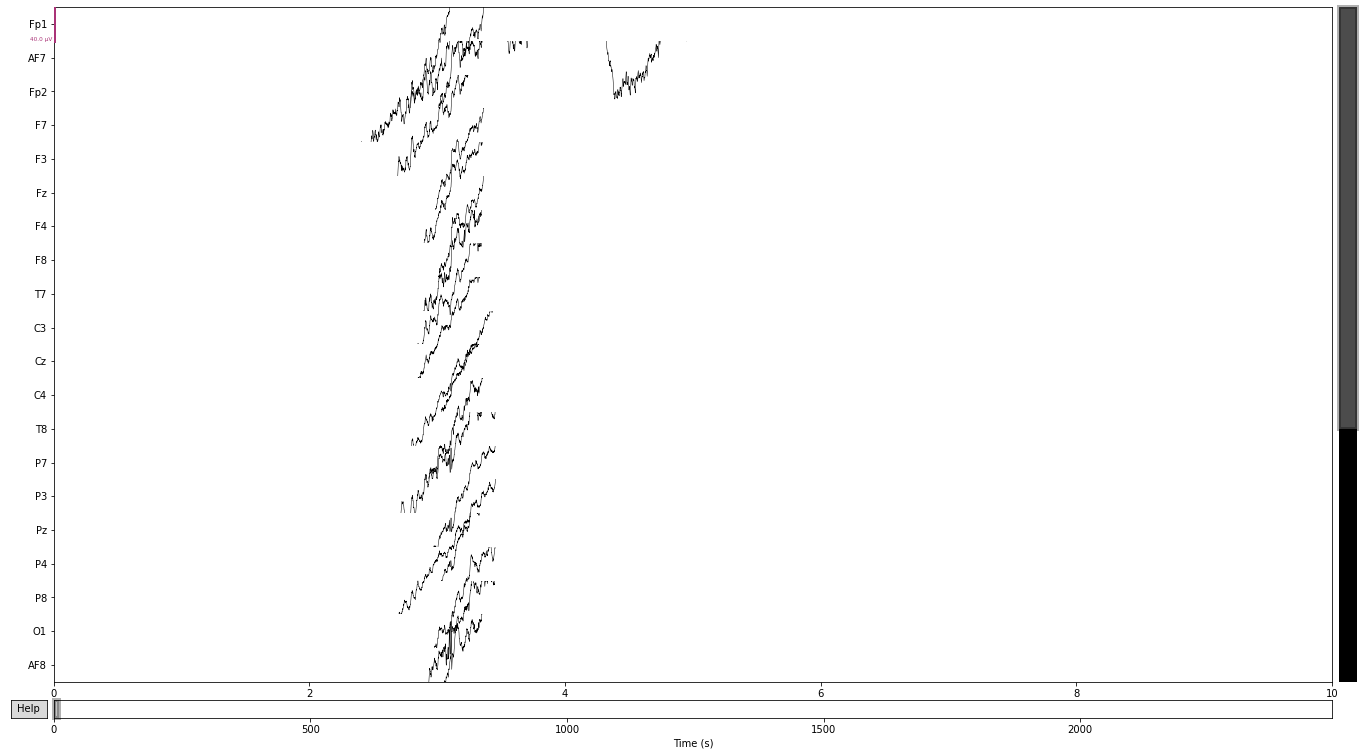

In [5]:
raw = raw_dataset.get_raw(data_row)
print(raw.info)
raw.plot();

## Feature Extraction
### Build Dataset (Demo)

In [7]:
available_features = ['max_cross_corr', 'phase_lock_val', 'nonlin_interdep', 'time_corr', 'spect_corr']
selected_feature = available_features[0]
package = 'surfCO'
patient = 'pat_3500'

raw_args = ['--dev', '-p', patient, '-f', selected_feature]

build_dataset.main(raw_args)

Starting build_dataset.py with fast_dev_mode=True at time 20211218T203424
WARNING! fast_dev_mode=True !!! Results are incomplete.
dumping results to C:\Users\noam\Repositories\noamsgl\msc\results/max_cross_corr/surfCO/pat_3500/20211218T203424
getting selected_func='max_cross_corr' for patient='pat_3500' from package='surfCO'
len(preictal_intervals)=2
len(interictal_intervals)=2
len(preictal_window_intervals)=2
len(interictal_window_intervals)=2


loading patient data: 100%|██████████| 61/61 [01:19<00:00,  1.31s/it]


len(preictal_raws)=2
starting to process preictal raws
dumping window_id=0 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/max_cross_corr/surfCO/pat_3500/20211218T203424/window_0.pkl'
dumping window_id=1 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/max_cross_corr/surfCO/pat_3500/20211218T203424/window_1.pkl'


loading patient data: 100%|██████████| 61/61 [02:57<00:00,  2.92s/it]


[<RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>, <RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>]
starting to process interictal raws
dumping window_id=2 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/max_cross_corr/surfCO/pat_3500/20211218T203424/window_2.pkl'
dumping window_id=3 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/max_cross_corr/surfCO/pat_3500/20211218T203424/window_3.pkl'
saving samples_df to samples_df_path='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/max_cross_corr/surfCO/pat_3500/20211218T203424/dataset.csv'


## Visualize Features
Assumes many datasets have been built

In [29]:
psp_dataset = PSPDataset(
    r"C:\Users\noam\Repositories\noamsgl\msc\results\epilepsiae\max_cross_corr\surfCO\pat_3500\20211213T182128")
X, labels = psp_dataset.get_X(), psp_dataset.get_labels(format='desc')

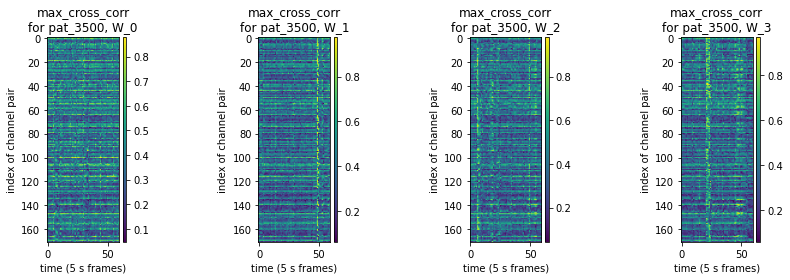

In [61]:
window_id = 5
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True)
for i in range(4):
    plot_feature_window(X[i].reshape(171, -1), patient_name=patient, window_name=f'W_{i}',
                                     feature_name=selected_feature, ax=axes[i])
plt.tight_layout()
plt.show()


## Visualize Datasets
We show a PCA projection to 2 dimensions for 12 different datasets.

In [89]:
datasets_df = get_datasets_df()
datasets_df

,feature_name,patient_name,data_dir
0,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,max_cross_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
2,max_cross_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
3,phase_lock_val,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,phase_lock_val,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
5,phase_lock_val,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
6,spect_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
7,spect_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
8,spect_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
9,time_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 1, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 2, dtype: object
plotting pca for feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object
plotting pca for feature_name                   

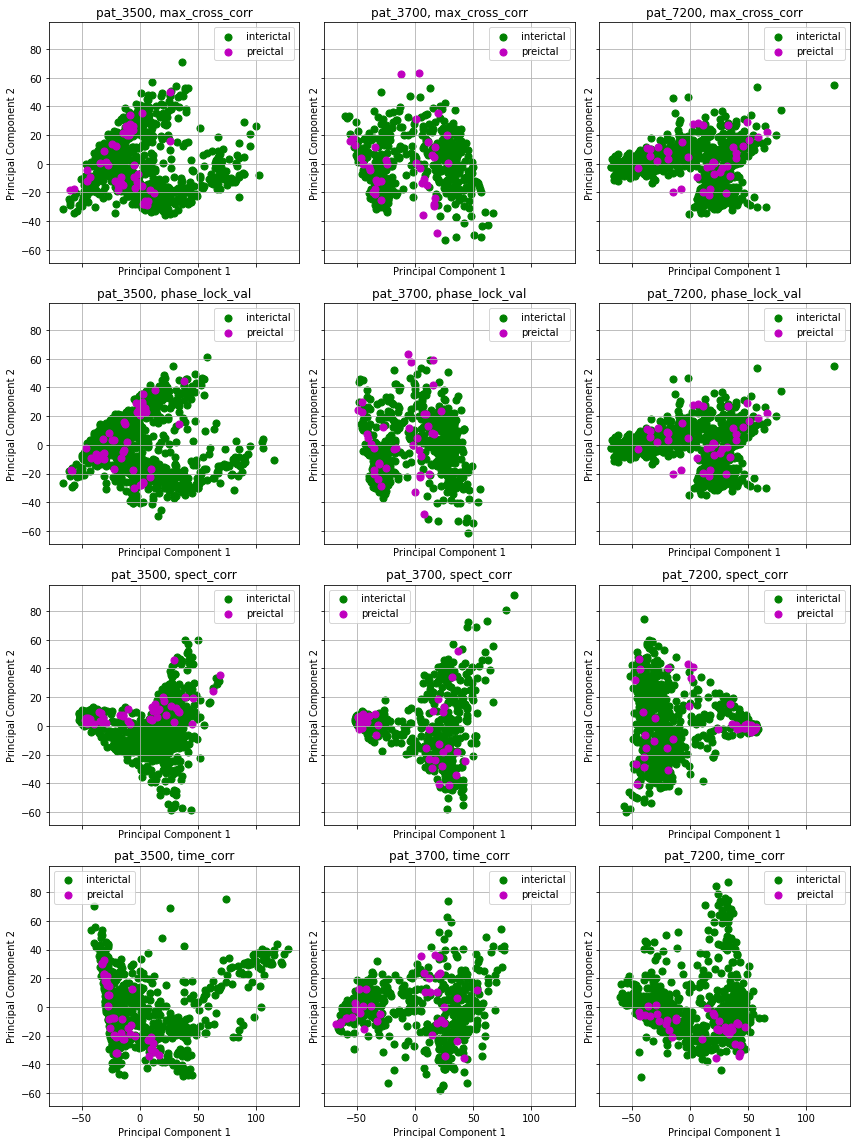

In [104]:

# plot_pca_projection(data_dir, ax=ax)
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    plot_pca_projection(datasets_df.sort_values(by=['feature_name', 'patient_name'], ignore_index=True).loc[i], ax=ax)
plt.tight_layout()
plt.show()


## Train Classifier on multiple feature datasets at once

In [64]:
feature_names = (
    'max_cross_corr',
    # 'phase_lock_val',
    # 'spect_corr',
    # 'time_corr'
)

patient_names = ['pat_3500']

classifier_names = [
    "Nearest Neighbors",
    # "Linear SVM",
    # "RBF SVM",
    # "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    # "Naive Bayes",
    # "QDA",
]
results = classifier_comparison.main(save_to_disk=False,
                                     feature_names=feature_names,
                                     patient_names=patient_names,
                                     classifier_names=classifier_names)

iterating datasets:   0%|          | 0/1 [00:00<?, ?it/s]

beginning ds=feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [06:57<00:47, 47.12s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

## Plot Classifier Results

In [65]:
results

,fold,fit_time,score_time,estimator,test_precision,test_recall,test_roc_auc,feature_name,patient_name,data_dir
0,0,0.015002,0.063000,KNeighborsClassifier(n_neighbors=3),0.951613,0.967213,0.577869,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,1,0.013999,0.039000,KNeighborsClassifier(n_neighbors=3),0.966102,0.934426,0.568306,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
2,2,0.011999,0.039001,KNeighborsClassifier(n_neighbors=3),0.953125,1.000000,0.751366,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
3,3,0.013000,0.040001,KNeighborsClassifier(n_neighbors=3),0.953125,1.000000,0.751366,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,4,0.011002,0.043999,KNeighborsClassifier(n_neighbors=3),0.949153,0.918033,0.385246,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
0,0,9.673390,3.342208,"SVC(C=0.025, kernel='linear')",0.938462,1.000000,0.889344,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,1,8.902947,3.255887,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.732240,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
2,2,9.382911,3.504369,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.885246,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
3,3,9.141287,3.079998,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.950820,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,4,8.687001,2.894479,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.672131,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


In [66]:
results

,fold,fit_time,score_time,estimator,test_precision,test_recall,test_roc_auc,feature_name,patient_name,data_dir
0,0,0.015002,0.063000,KNeighborsClassifier(n_neighbors=3),0.951613,0.967213,0.577869,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,1,0.013999,0.039000,KNeighborsClassifier(n_neighbors=3),0.966102,0.934426,0.568306,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
2,2,0.011999,0.039001,KNeighborsClassifier(n_neighbors=3),0.953125,1.000000,0.751366,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
3,3,0.013000,0.040001,KNeighborsClassifier(n_neighbors=3),0.953125,1.000000,0.751366,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,4,0.011002,0.043999,KNeighborsClassifier(n_neighbors=3),0.949153,0.918033,0.385246,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
0,0,9.673390,3.342208,"SVC(C=0.025, kernel='linear')",0.938462,1.000000,0.889344,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,1,8.902947,3.255887,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.732240,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
2,2,9.382911,3.504369,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.885246,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
3,3,9.141287,3.079998,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.950820,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,4,8.687001,2.894479,"SVC(C=0.025, kernel='linear')",0.953125,1.000000,0.672131,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


## Variable Selection

In [ ]:
import os

print(os.getcwd())